<a href="https://colab.research.google.com/github/devdogukan/turkish-sentiment-analysis/blob/main/turkish-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import string
import nltk
from nltk.corpus import stopwords
import snowballstemmer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 10
MAX_VOCAB_SIZE = 20000
DEVICE

device(type='cuda')

In [4]:
stemmer = snowballstemmer.stemmer("turkish")
nltk.download("stopwords")
stop_words = set(stopwords.words("turkish"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def clean_text(text):
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    tokens = [stemmer.stemWord(word) for word in text.split() if word not in stop_words and not word.isdigit()]
    return " ".join(tokens)

In [15]:
df = pd.read_csv("/content/drive/MyDrive/tsa-dataset.csv")
df.rename(columns={"review": "text", "score": "label"}, inplace=True)
df.head()

,id,label,text
0,0,Positive,Kokusu çok güzel etkisi de efsane
1,1,Negative,hiç bir fark olmadı siyah nokta silmedi
2,2,Positive,şeffaf güzel bir krem elimi yumuşacık yaptı
3,3,Positive,Özellikle karma ve hassas cildiniz varsa La Ro...
4,4,Negative,çok iyi nemlendiriyor ama daha ucuz muadilleri...


In [16]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [17]:
label2id = { "Positive": 0, "Neutral": 1, "Negative": 2 }
id2label = {v: k for k, v in label2id.items()}

train_df["label_id"] = train_df["label"].map(label2id)
test_df["label_id"] = test_df["label"].map(label2id)

In [18]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

train_df["tokens"] = train_df["clean_text"].apply(lambda x: x.split())
test_df["tokens"] = test_df["clean_text"].apply(lambda x: x.split())

In [19]:
from collections import Counter
class Vocab:
    def __init__(self, counter, max_size=20000, specials=["<unk>", "<pad>"]):
        self.itos = specials + [tok for tok, _ in counter.most_common(max_size)]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}
        self.unk_index = self.stoi["<unk>"]

    def __getitem__(self, token):
        return self.stoi.get(token, self.unk_index)

    def __len__(self):
        return len(self.itos)

counter = Counter()
for tokens in train_df["tokens"]:
    counter.update(tokens)
vocab = Vocab(counter, max_size=MAX_VOCAB_SIZE)

In [20]:
class SentimentDataset(Dataset):
    def __init__(self, df, vocab):
        self.tokens = df["tokens"].tolist()
        self.labels = df["label_id"].tolist()
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        token_ids = [self.vocab[tok] for tok in self.tokens[idx]]
        return torch.tensor(token_ids), torch.tensor(self.labels[idx])

In [21]:
def collate_fn(batch):
    batch = [(x, y) for x, y in batch if len(x) > 0]
    if not batch:
        return None
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs])
    padded = pad_sequence(seqs, batch_first=True, padding_value=vocab["<pad>"])
    return padded, lengths, torch.tensor(labels)

In [22]:
train_dataset = SentimentDataset(train_df, vocab)
test_dataset = SentimentDataset(test_df, vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [23]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h = self.gru(packed)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(self.dropout(h))

In [24]:
def eval_epoch(loader):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            if batch is None: continue
            x, lengths, y = [b.to(DEVICE) for b in batch]
            out = model(x, lengths)
            loss = criterion(out, y)
            total_loss += loss.item() * len(y)
            preds += out.argmax(1).cpu().tolist()
            labels += y.cpu().tolist()

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    classification_report_ = classification_report(labels, preds, target_names=label2id.keys())
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label2id, yticklabels=label2id)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return avg_loss, acc, prec, rec, f1, classification_report_

In [25]:
def train_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, patience=2, save_path="model.pth"):
    best_f1 = 0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for batch in train_loader:
            if batch is None: continue
            x, lengths, y = [b.to(device) for b in batch]
            optimizer.zero_grad()
            out = model(x, lengths)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(y)
            preds += out.argmax(1).detach().cpu().tolist()
            labels += y.cpu().tolist()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = accuracy_score(labels, preds)

        # ------------------- Validation -------------------
        val_loss, val_acc, val_prec, val_rec, val_f1, classification_report_ = eval_epoch(val_loader)

        print(f"\nEpoch {epoch+1} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}\n")
        print(classification_report_)

        # ------------------- Early Stopping -------------------
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict()
            patience_counter = 0
            print("Yeni en iyi model kaydedildi.")
        else:
            patience_counter += 1
            print(f"Gelişme yok. (Patience: {patience_counter}/{patience})")

            if patience_counter >= patience:
                print("Early stopping devreye girdi.")
                break
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), save_path)
        print(f"En iyi model geri yüklendi ve {save_path} olarak kaydedildi. (F1 = {best_f1:.4f})")

    return model

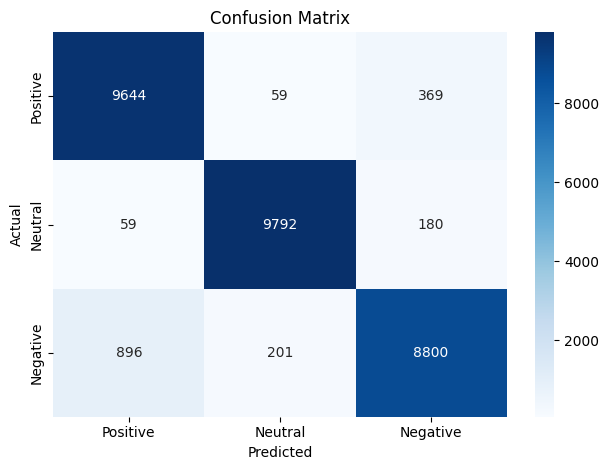


Epoch 1 | train_loss=0.2480 acc=0.9061 | val_loss=0.1638 acc=0.9412 f1=0.9409

              precision    recall  f1-score   support

    Positive       0.91      0.96      0.93     10072
     Neutral       0.97      0.98      0.98     10031
    Negative       0.94      0.89      0.91      9897

    accuracy                           0.94     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.94      0.94      0.94     30000

Yeni en iyi model kaydedildi.


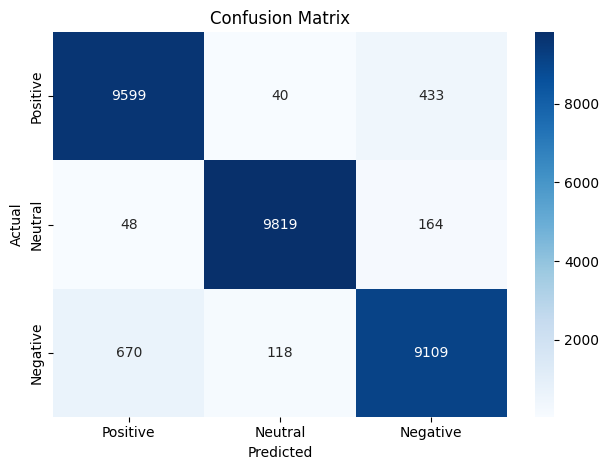


Epoch 2 | train_loss=0.1291 acc=0.9549 | val_loss=0.1412 acc=0.9509 f1=0.9508

              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94     10072
     Neutral       0.98      0.98      0.98     10031
    Negative       0.94      0.92      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Yeni en iyi model kaydedildi.


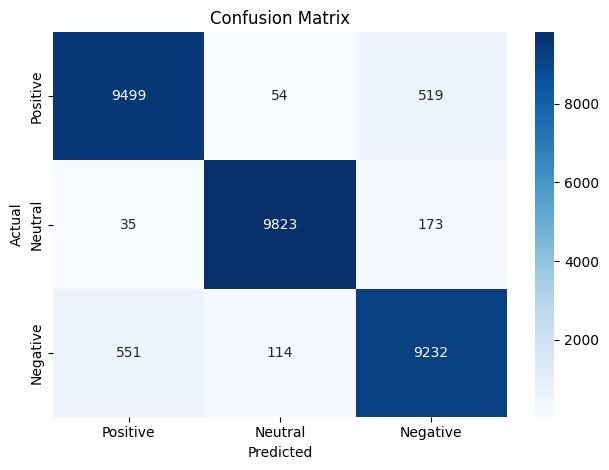


Epoch 3 | train_loss=0.0916 acc=0.9682 | val_loss=0.1471 acc=0.9518 f1=0.9518

              precision    recall  f1-score   support

    Positive       0.94      0.94      0.94     10072
     Neutral       0.98      0.98      0.98     10031
    Negative       0.93      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Yeni en iyi model kaydedildi.


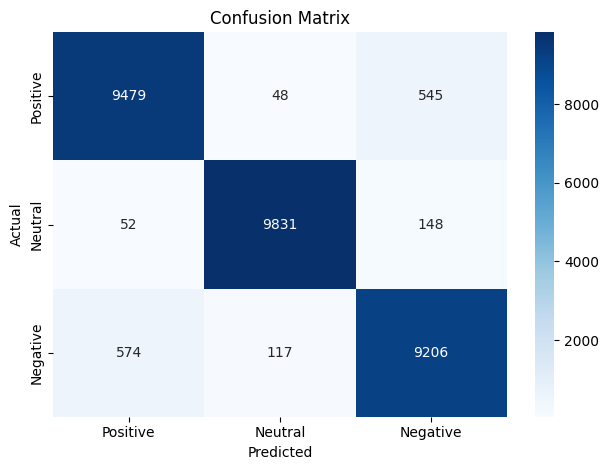


Epoch 4 | train_loss=0.0677 acc=0.9771 | val_loss=0.1540 acc=0.9505 f1=0.9505

              precision    recall  f1-score   support

    Positive       0.94      0.94      0.94     10072
     Neutral       0.98      0.98      0.98     10031
    Negative       0.93      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Gelişme yok. (Patience: 1/3)


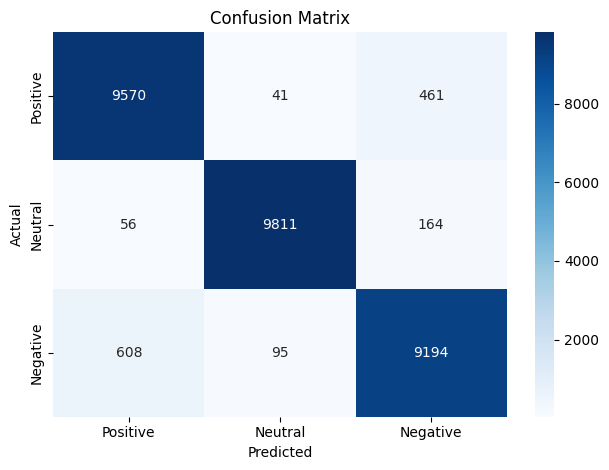


Epoch 5 | train_loss=0.0516 acc=0.9828 | val_loss=0.1589 acc=0.9525 f1=0.9525

              precision    recall  f1-score   support

    Positive       0.94      0.95      0.94     10072
     Neutral       0.99      0.98      0.98     10031
    Negative       0.94      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Yeni en iyi model kaydedildi.


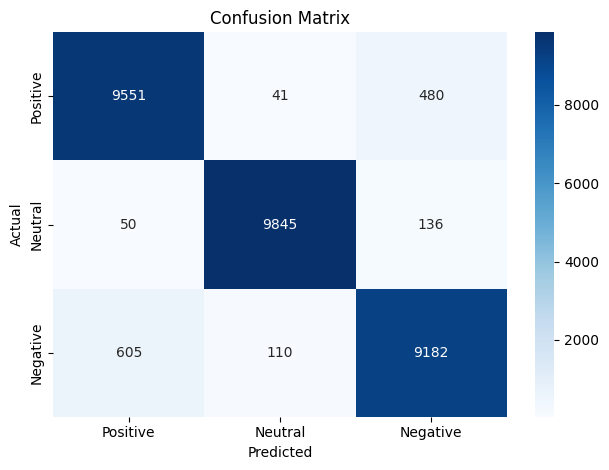


Epoch 6 | train_loss=0.0404 acc=0.9865 | val_loss=0.1824 acc=0.9526 f1=0.9525

              precision    recall  f1-score   support

    Positive       0.94      0.95      0.94     10072
     Neutral       0.98      0.98      0.98     10031
    Negative       0.94      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Yeni en iyi model kaydedildi.


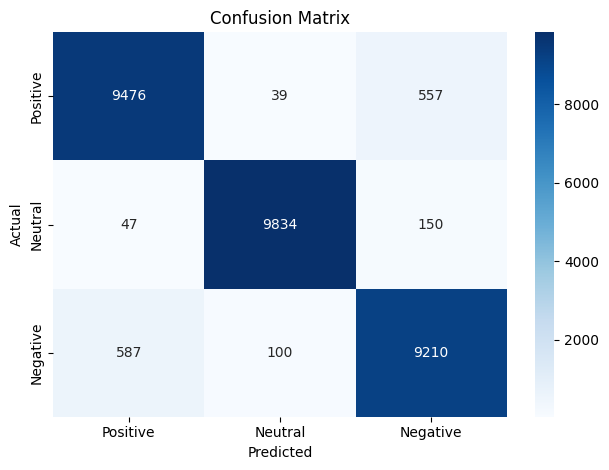


Epoch 7 | train_loss=0.0329 acc=0.9888 | val_loss=0.1957 acc=0.9507 f1=0.9506

              precision    recall  f1-score   support

    Positive       0.94      0.94      0.94     10072
     Neutral       0.99      0.98      0.98     10031
    Negative       0.93      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Gelişme yok. (Patience: 1/3)


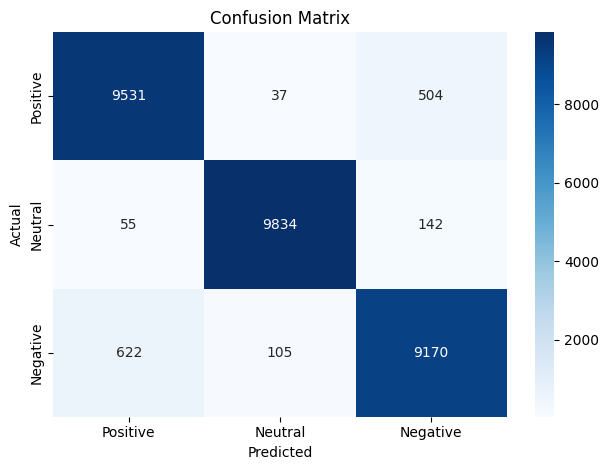


Epoch 8 | train_loss=0.0293 acc=0.9899 | val_loss=0.2019 acc=0.9512 f1=0.9511

              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94     10072
     Neutral       0.99      0.98      0.98     10031
    Negative       0.93      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Gelişme yok. (Patience: 2/3)


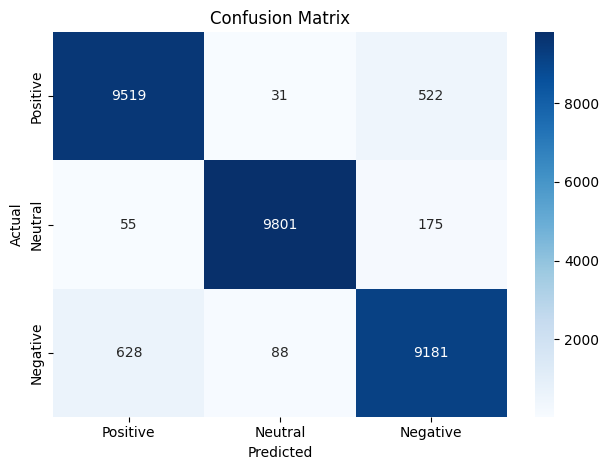


Epoch 9 | train_loss=0.0250 acc=0.9912 | val_loss=0.2085 acc=0.9500 f1=0.9500

              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94     10072
     Neutral       0.99      0.98      0.98     10031
    Negative       0.93      0.93      0.93      9897

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

Gelişme yok. (Patience: 3/3)
Early stopping devreye girdi.
En iyi model geri yüklendi ve model.pth olarak kaydedildi. (F1 = 0.9525)


In [26]:
VOCAB_SIZE = len(vocab)
PAD_IDX = vocab["<pad>"]
model = GRUClassifier(VOCAB_SIZE, 128, 128, len(label2id), PAD_IDX).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=EPOCHS,
    patience=3,
    save_path="model.pth"
)

In [27]:
import pickle

with open("stoi.pkl", "wb") as f:
    pickle.dump(vocab.stoi, f)

with open("itos.pkl", "wb") as f:
    pickle.dump(vocab.itos, f)